In [70]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table
import torch
import gpytorch

### Seasonality

Data is collected at 5 minute intervals over a 10 day timespan

Frequency = Number of observations per _season_ or _cycle_

Season = Hour, Day, Week, Month, Quarter, Year

_Note_: In Fourier analysis, “period” is the length of the cycle, and “frequency” is the inverse of period

Daily seasonality frequency of $288 = (24 * 60) / 5$

Day of week seasonality frequency of $2016 = (288 * 7)$

Work Week seasonality frequency of $1440 = (288 * 5)$

In [71]:
sigma_line = query_table(table='uv_sigma_line_eg_15T')
#sigma_line = pd.read_csv('/Users/wastechs/Downloads/machine_day12.csv')

In [52]:
px.line(data_frame=sigma_line, x=sigma_line.index, y='p')

### Scale $X$ between [0-1] and use double precision

In [15]:
sigma_line.shape

(961, 8)

In [137]:
#sigma_line = sigma_line[sigma_line.index.day >= 12] ## for pedagoical reasons

time_int_range = np.arange(0, 1728*5, 5)
sigma_line['t'] = time_int_range

X = (sigma_line['t'].values - np.min(sigma_line['t'].values)) / (np.max(sigma_line['t'].values) - np.min(sigma_line['t'].values))
y = sigma_line['kw'].values

n = len(X)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = torch.from_numpy(X[:n_train]).to(torch.double)
y_train = torch.from_numpy(y[:n_train]).to(torch.double)

y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

X_test = torch.from_numpy(X[n_train:]).to(torch.double)
y_test = torch.from_numpy(y[n_train:]).to(torch.double)

### Keep $X$ the same and use float32

In [72]:
time_int_range = np.arange(0, 576*15, 15)

all = sigma_line[sigma_line.index.day >= 12]

all['t'] = time_int_range

X = all['t'].values
y = all['kw'].values

n = len(X)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = torch.from_numpy(X[:n_train]).to(torch.float32)
y_train = torch.from_numpy(y[:n_train]).to(torch.float32)

y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

X_test = torch.from_numpy(X[n_train:]).to(torch.float32)
y_test = torch.from_numpy(y[n_train:]).to(torch.float32)

px.line(x=X_train.numpy(), y=y_train.numpy())
#px.line(x=X_test.numpy(), y=y_test.numpy())

/var/folders/5n/lzw120x534d6n5nbhk8qwzjr0000gs/T/ipykernel_14039/2173459643.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
X_test = torch.arange(0, 8625, 15).to(torch.float32)

# 6030 - train
# 6045 - test

In [107]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        period_prior = gpytorch.priors.NormalPrior(195, 1.5)
        period_constraint = gpytorch.constraints.Interval(160, 220)
        outputscale_prior = gpytorch.priors.GammaPrior(0.5, 0.15)
        #lengthscale_prior = gpytorch.priors.NormalPrior(15, 1.5)
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_prior=period_prior,
                period_length_constraint=period_constraint
                ) * gpytorch.kernels.RBFKernel(
                    #lengthscale_prior=lengthscale_prior
                ),
                outputscale_prior=outputscale_prior
            )

        # Initialize lengthscale and output scale to mean of priors
        #self.covar_module.outputscale = outputscale_prior.mean
        #self.covar_module.base_kernel.lengthscale = lengthscale_prior
        #self.covar_module.base_kernel.period_length = 30

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

Actual learned parameters of the model are things like raw_noise, raw_outputscale, raw_lengthscale, etc. The reason for this is that these parameters must be positive

In [108]:
print('Actual outputscale:', model.covar_module.outputscale)

Actual outputscale: tensor(0.6931, grad_fn=<SoftplusBackward0>)


In [109]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale',
              tensor([[0.]])),
             ('covar_module.base_kernel.kernels.0.raw_period_length',
              tensor([[0.]])),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.kernels.0.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.base_kernel.kernels.0.period_length_prior.loc',
              tensor(195.)),
             ('covar_module.base_kernel.kernels.0.period_length_prior.sc

In [110]:
#model.double()
#likelihood.double()

model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [111]:
with gpytorch.settings.max_cg_iterations(5000):
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes Gaussian Likelihood parameters
        ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 300
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        
        # Output from model
        output = model(X_train)

        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()

        if (i % 20) == 0:
            print('Iter %d/%d - Loss: %.3f noise: %.6f' % (
                i + 1, training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
            print(list(model.parameters()))
        optimizer.step()

Iter 1/300 - Loss: 2.507 noise: 0.693247
[Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor(0., requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True)]
Iter 21/300 - Loss: 2.177 noise: 0.793164
[Parameter containing:
tensor([0.1908], requires_grad=True), Parameter containing:
tensor([0.1969], requires_grad=True), Parameter containing:
tensor(0.1907, requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True), Parameter containing:
tensor([[0.1896]], requires_grad=True), Parameter containing:
tensor([[0.2010]], requires_grad=True)]
Iter 41/300 - Loss: 1.970 noise: 0.873576
[Parameter containing:
tensor([0.3331], requires_grad=True), Parameter containing:
tensor([0.3796], requires_grad=True), Parameter containing:
tensor(0.3326, requires_grad=T

In [112]:
raw_outputscale = model.covar_module.raw_outputscale
constraint = model.covar_module.raw_outputscale_constraint

print('Transformed outputscale: ', constraint.transform(raw_outputscale))

Transformed outputscale:  tensor(0.1067, grad_fn=<SoftplusBackward0>)


In [113]:
print('Actual outputscale:', model.covar_module.outputscale)

Actual outputscale: tensor(0.1067, grad_fn=<SoftplusBackward0>)


In [114]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(9000):
    #test_x = test_x.to(torch.float32)
    test_pred = likelihood(model(X_test))
    #train_pred = likelihood(model(X_train))

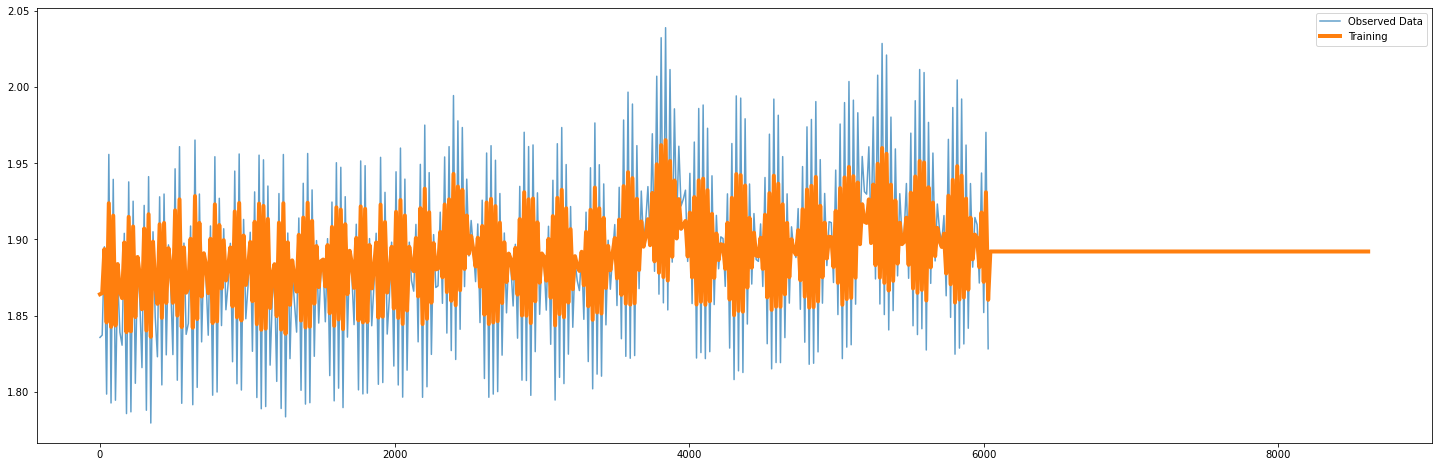

In [115]:
with torch.no_grad():

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(25, 8))
    # Get upper and lower confidence bounds
    #lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), y_train.numpy(), alpha=0.7)
    #ax.plot(X_train.numpy(), train_pred.mean.numpy())
    # Plot predictive means as blue line
    #ax.plot(X_test.numpy(), y_test.numpy())
    ax.plot(X_test.numpy(), test_pred.mean.numpy(), lw=4)
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    ax.legend(['Observed Data', 'Training', 'Test', 'Predictions'])